# 卷积神经网络中的经典数据结构

- LeNet
- AlexNet
- VGG
- GoogleNet
- ResNet
- DenseNet

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt

# 加载FashiMNist数据集

In [2]:
trans = torchvision.transforms.ToTensor()
training_data = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=True,
    download=True,
    transform=trans
)
testing_data = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=False,
    download=True,
    transform=trans
)

现代深度神经网络都是在ImageNet上提出的，所以针对的输入都是224x224，为了后续的演示，所以这里我们使用Resize预处理，把输入图像拉大为224x224，重新做一份数据集

In [3]:
trans = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])
training_data_224 = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=True,
    download=True,
    transform=trans
)
testing_data_224 = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=False,
    download=True,
    transform=trans
)

# 辅助函数

In [4]:
def accuracy(y_hat, y):
    max_indices = torch.max(y_hat, dim=1)[1]
    return (y == max_indices).to(dtype=torch.float32).mean()


def accuracy_on(model, data_iter):
    acc = []
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        acc.append(accuracy(y_hat, y))
    return torch.tensor(acc).mean().item()


def train(training_iter, testing_iter, model, loss, optimizer, device, epoch=20, plot=True):
    training_loss = []
    training_acc = []
    testing_acc = []
    for i in range(epoch):
        epoch_loss = 0
        epoch_acc = 0
        for X, y in training_iter:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            l = loss(y_hat, y)
            epoch_loss += l.item()
            epoch_acc += accuracy(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        training_loss.append(epoch_loss / len(training_iter))
        training_acc.append(epoch_acc / len(training_iter))
        testing_acc.append(accuracy_on(model, testing_iter))
        print(
            f'the loss of epoch {i}: {training_loss[-1]:.4f}, accuracy on training set: {training_acc[-1]:.4f}, accuracy on testing set: {testing_acc[-1]:.4f}')
    if plot == False:
        return
    plt.plot(training_loss, label='training_loss')
    plt.plot(training_acc, label='training_acc')
    plt.plot(testing_acc, label='testing_acc')
    plt.legend()
    plt.show()

# 构建LeNet模型

<img src='./images/lenet.svg' width=900>

- 默认结构下，必须使用大的学习率>0.5，如果使用0.1，则模型训练的非常慢，至少要10个epoch以上
- 如果Conv后不加Sigmoid，则可以使用学习率0.1即可。
- 原来尝试的batch_size是256，acc只能到85%左右，后来不经意调整为了25，发现acc轻松到90

In [9]:
LeNet = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(400, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84,10)
)

x = torch.randn(1,1,28,28)

# 可以看一下每一层网络输出数据的尺寸
for m in LeNet:
    x = m(x)
    print(f'the output shape of {m.__class__.__name__}:\t{x.shape}')

the output shape of Conv2d:	torch.Size([1, 6, 28, 28])
the output shape of Sigmoid:	torch.Size([1, 6, 28, 28])
the output shape of AvgPool2d:	torch.Size([1, 6, 14, 14])
the output shape of Conv2d:	torch.Size([1, 16, 10, 10])
the output shape of Sigmoid:	torch.Size([1, 16, 10, 10])
the output shape of AvgPool2d:	torch.Size([1, 16, 5, 5])
the output shape of Flatten:	torch.Size([1, 400])
the output shape of Linear:	torch.Size([1, 120])
the output shape of Sigmoid:	torch.Size([1, 120])
the output shape of Linear:	torch.Size([1, 84])
the output shape of Sigmoid:	torch.Size([1, 84])
the output shape of Linear:	torch.Size([1, 10])


the loss of epoch 0: 2.1379, accuracy on training set: 0.1676, accuracy on testing set: 0.5431
the loss of epoch 1: 0.7792, accuracy on training set: 0.6898, accuracy on testing set: 0.7282
the loss of epoch 2: 0.5812, accuracy on training set: 0.7736, accuracy on testing set: 0.7667
the loss of epoch 3: 0.4942, accuracy on training set: 0.8121, accuracy on testing set: 0.7944
the loss of epoch 4: 0.4415, accuracy on training set: 0.8340, accuracy on testing set: 0.8125
the loss of epoch 5: 0.4069, accuracy on training set: 0.8486, accuracy on testing set: 0.8377
the loss of epoch 6: 0.3799, accuracy on training set: 0.8583, accuracy on testing set: 0.8425
the loss of epoch 7: 0.3607, accuracy on training set: 0.8650, accuracy on testing set: 0.8433
the loss of epoch 8: 0.3434, accuracy on training set: 0.8711, accuracy on testing set: 0.8641
the loss of epoch 9: 0.3290, accuracy on training set: 0.8760, accuracy on testing set: 0.8553
the loss of epoch 10: 0.3187, accuracy on training

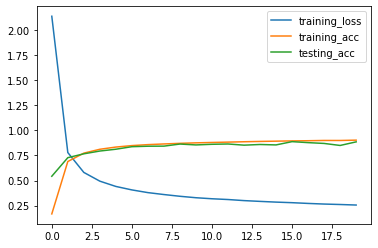

In [4]:
batch_size = 64
learning_rate = 0.9
epoch = 20
device = torch.device('cuda:3')

training_iter = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
testing_iter = torch.utils.data.DataLoader(testing_data, batch_size=batch_size)

model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(400, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84,10)
)
def parameters_init(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
model.apply(parameters_init)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train(training_iter, testing_iter, model, loss, optimizer, device=device, epoch=epoch, plot=True)

# AlexNet

AlexNet是第一个在大规模视觉竞赛中击败传统计算机视觉模型的大型神经网络；

**由手工特征+机器学习到端到端的深度神经网络**

在AlexNet之前，CV领域往往非常重视对输入图像数据的预处理（结合光学、几何学等）以及手工特征的设计，而对于分类算法的选择就没有那么热衷。而机器学习领域追求的是有效的证明与数学支撑，在收敛性、泛化性、优化求解上面追求更严谨的数学证明。

**为什么LeNet出现那么早，CNN后来没有火热起来**

- 数据、算力的缺乏
- 网络设计上的技巧缺乏：启发式参数初始化、随机梯度下降的巧妙变体、新的激活单元、正则化技术等。

<img src='images/alexnet.svg'>

**和LeNet的不同**

1. 最大的不同就是卷积部分多了3个连续的卷积层，让整个网络更深了。
2. Sigmoid换成了ReLU，让网络更深时，梯度下降更有效一些
3. 全连接层后面加入了Dropout防止过拟合
4. AvgPool换成了MaxPool

In [5]:
AlexNet = nn.Sequential(
    # 因为输出图像尺寸大，所以kernel size选择的比较大，stride选择4，可以让空间分辨率快速下降
    nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，池化层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1),nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1),nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过度拟合
    nn.Linear(6400, 4096), nn.ReLU(),nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),nn.Dropout(p=0.5),
    nn.Linear(4096,10)
)
x = torch.randn(1,3,224,224)

# 可以看一下每一层网络输出数据的尺寸
for m in AlexNet:
    x = m(x)
    print(f'the output shape of {m.__class__.__name__}:\t{x.shape}')

the output shape of Conv2d:	torch.Size([1, 96, 54, 54])
the output shape of ReLU:	torch.Size([1, 96, 54, 54])
the output shape of MaxPool2d:	torch.Size([1, 96, 26, 26])
the output shape of Conv2d:	torch.Size([1, 256, 26, 26])
the output shape of ReLU:	torch.Size([1, 256, 26, 26])
the output shape of MaxPool2d:	torch.Size([1, 256, 12, 12])
the output shape of Conv2d:	torch.Size([1, 384, 12, 12])
the output shape of ReLU:	torch.Size([1, 384, 12, 12])
the output shape of Conv2d:	torch.Size([1, 384, 12, 12])
the output shape of ReLU:	torch.Size([1, 384, 12, 12])
the output shape of Conv2d:	torch.Size([1, 256, 12, 12])
the output shape of ReLU:	torch.Size([1, 256, 12, 12])
the output shape of MaxPool2d:	torch.Size([1, 256, 5, 5])
the output shape of Flatten:	torch.Size([1, 6400])
the output shape of Linear:	torch.Size([1, 4096])
the output shape of ReLU:	torch.Size([1, 4096])
the output shape of Dropout:	torch.Size([1, 4096])
the output shape of Linear:	torch.Size([1, 4096])
the output shap

下面我们使用AlexNet训练

the loss of epoch 0: 0.9399, accuracy on training set: 0.6499, accuracy on testing set: 0.7893
the loss of epoch 1: 0.4818, accuracy on training set: 0.8219, accuracy on testing set: 0.8332
the loss of epoch 2: 0.4003, accuracy on training set: 0.8530, accuracy on testing set: 0.8258
the loss of epoch 3: 0.3532, accuracy on training set: 0.8700, accuracy on testing set: 0.8680
the loss of epoch 4: 0.3257, accuracy on training set: 0.8784, accuracy on testing set: 0.8787
the loss of epoch 5: 0.3047, accuracy on training set: 0.8878, accuracy on testing set: 0.8833
the loss of epoch 6: 0.2874, accuracy on training set: 0.8931, accuracy on testing set: 0.8851
the loss of epoch 7: 0.2726, accuracy on training set: 0.9002, accuracy on testing set: 0.8953
the loss of epoch 8: 0.2599, accuracy on training set: 0.9042, accuracy on testing set: 0.8931
the loss of epoch 9: 0.2483, accuracy on training set: 0.9093, accuracy on testing set: 0.8990


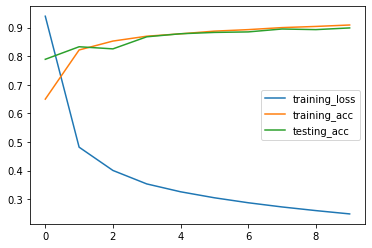

In [7]:
batch_size = 128
learning_rate = 0.03
epoch = 10
device = torch.device('cuda:3')

training_iter = torch.utils.data.DataLoader(training_data_224, batch_size=batch_size, shuffle=True)
testing_iter = torch.utils.data.DataLoader(testing_data_224, batch_size=batch_size)

model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1),nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1),nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(),nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),nn.Dropout(p=0.5),
    nn.Linear(4096,10)
)

def parameters_init(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
model.apply(parameters_init)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train(training_iter, testing_iter, model, loss, optimizer, device=device, epoch=epoch, plot=True)

手动魔改一下整个网络，让整个网络更小一些，看看效果。

the loss of epoch 0: 0.9732, accuracy on training set: 0.6323, accuracy on testing set: 0.7653
the loss of epoch 1: 0.5441, accuracy on training set: 0.7995, accuracy on testing set: 0.8131
the loss of epoch 2: 0.4523, accuracy on training set: 0.8331, accuracy on testing set: 0.8308
the loss of epoch 3: 0.4025, accuracy on training set: 0.8525, accuracy on testing set: 0.8404
the loss of epoch 4: 0.3722, accuracy on training set: 0.8649, accuracy on testing set: 0.8634
the loss of epoch 5: 0.3505, accuracy on training set: 0.8728, accuracy on testing set: 0.8658
the loss of epoch 6: 0.3323, accuracy on training set: 0.8782, accuracy on testing set: 0.8650
the loss of epoch 7: 0.3136, accuracy on training set: 0.8853, accuracy on testing set: 0.8796
the loss of epoch 8: 0.3047, accuracy on training set: 0.8894, accuracy on testing set: 0.8839
the loss of epoch 9: 0.2896, accuracy on training set: 0.8942, accuracy on testing set: 0.8787


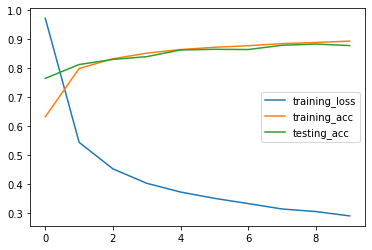

In [8]:
batch_size = 128
learning_rate = 0.03
epoch = 10
device = torch.device('cuda:3')

training_iter = torch.utils.data.DataLoader(training_data_224, batch_size=batch_size, shuffle=True)
testing_iter = torch.utils.data.DataLoader(testing_data_224, batch_size=batch_size)

model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=11, stride=4), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(in_channels=32, out_channels=128, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 这里把3层CNN改为2层
    nn.Conv2d(128, 256, kernel_size=3, padding=1),nn.ReLU(),
    nn.Conv2d(256, 128, kernel_size=3, padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 降低全连接层的隐藏层个数
    nn.Linear(3200, 1000), nn.ReLU(),nn.Dropout(p=0.5),
    nn.Linear(1000, 256), nn.ReLU(),nn.Dropout(p=0.5),
    nn.Linear(256,10)
)
def parameters_init(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        
model.apply(parameters_init)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train(training_iter, testing_iter, model, loss, optimizer, device=device, epoch=epoch, plot=True)

# VGG

2014年，牛津大学计算机视觉组（**V**isual **G**eometry **G**roup）和Google DeepMind公司的研究员一起研发出了新的深度卷积神经网络：VGGNet，并取得了ILSVRC2014比赛分类项目的第二名（第一名是GoogLeNet，也是同年提出的).

论文名为：Very Deep Convolutional Networks for Large-Scale Image Recognition。论文主要针对卷积神经网络的深度对大规模图像集识别精度的影响，主要贡献是**使用很小的卷积核(3×3)构建各种深度的卷积神经网络结构**，并对这些网络结构进行了评估，最终证明16-19层的网络深度，能够取得较好的识别精度。 这也就是常用来提取图像特征的VGG-16和VGG-19。

<img src='./images/vgg_arch.jpg' width=600>

**与AlexNet的对比**

- 在VGG网络中只使用3x3，pad=1的卷积，这样的卷积不会改变空间尺寸。非常统一，简洁。另外在使用多层3x3的卷积核是可以等效达到7x7和11x11卷积核心的效果。3个连续的3x3卷积核心相当于一个7x7卷积核心的感受野，但参数量却由原来的49变成了27。

<img src='images/vgg_kernel.png'>

- 另外在VGG的block结构中每个卷积层后面都有一个非线性的ReLU层，这样也增加了整个网络非线性映射的能力。
- 使用连续的小卷积核代替大的卷积核，网络的深度更深，并且对边缘进行填充，卷积的过程并不会降低图像尺寸。仅使用小的池化单元，降低图像的尺寸。
- 通道数更多，特征度更宽。每个通道代表着一个FeatureMap，更多的通道数表示更丰富的图像特征。VGG网络第一层的通道数为64，后面每层都进行了翻倍，最多到512个通道，通道数的增加，使得更多的信息可以被提取出来。

**VGG系列**

论文中给出了不同block配置下的5种不同的网络结构，每种网络结构具有的block的数都是5个，而后是3个全连接，不同的在于，每个block中卷积层的个数，以及每个卷积层的通道数不同。

<img src='./images/vgg_configurations.png'>

In [6]:
def VGGBlock(num_layers, in_channels, out_channels):
    vgg_block = nn.Sequential()
    i = 0
    for _ in range(num_layers):
        vgg_block.add_module(str(i), nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        vgg_block.add_module(str(i + 1), nn.ReLU())
        in_channels = out_channels
        i += 2
    vgg_block.add_module(str(i), nn.MaxPool2d(kernel_size=2, stride=2))
    return vgg_block
vgg16 = nn.Sequential(
    VGGBlock(2, 3, 64),
    VGGBlock(2, 64, 128),
    VGGBlock(3, 128, 256),
    VGGBlock(3, 256, 512),
    VGGBlock(3, 512, 512),
    nn.Flatten(),
    nn.Linear(7*7*512, 4096),
    nn.Linear(4096, 4096),
    nn.Linear(4096, 1000),
)
vgg19 = nn.Sequential(
    VGGBlock(2, 3, 64),
    VGGBlock(2, 64, 128),
    VGGBlock(4, 128, 256),
    VGGBlock(4, 256, 512),
    VGGBlock(4, 512, 512),
    nn.Flatten(),
    nn.Linear(7*7*512, 4096),
    nn.Linear(4096, 4096),
    nn.Linear(4096, 1000),
)

In [21]:
x  = torch.randn(1, 3, 224, 224)
for m in vgg19:
    x = m(x)
    print(f'{m.__class__.__name__}: {x.shape}')

Sequential: torch.Size([1, 64, 112, 112])
Sequential: torch.Size([1, 128, 56, 56])
Sequential: torch.Size([1, 256, 28, 28])
Sequential: torch.Size([1, 512, 14, 14])
Sequential: torch.Size([1, 512, 7, 7])
Flatten: torch.Size([1, 25088])
Linear: torch.Size([1, 4096])
Linear: torch.Size([1, 4096])
Linear: torch.Size([1, 1000])


在我们的FashionMNIST数据集上用个简化的vgg网络试一下

the loss of epoch 0: 0.9120, accuracy on training set: 0.6760, accuracy on testing set: 0.8505
the loss of epoch 1: 0.3608, accuracy on training set: 0.8686, accuracy on testing set: 0.8675
the loss of epoch 2: 0.2993, accuracy on training set: 0.8921, accuracy on testing set: 0.8919
the loss of epoch 3: 0.2669, accuracy on training set: 0.9036, accuracy on testing set: 0.8941
the loss of epoch 4: 0.2447, accuracy on training set: 0.9107, accuracy on testing set: 0.9048
the loss of epoch 5: 0.2262, accuracy on training set: 0.9171, accuracy on testing set: 0.9009
the loss of epoch 6: 0.2114, accuracy on training set: 0.9224, accuracy on testing set: 0.9100
the loss of epoch 7: 0.1977, accuracy on training set: 0.9274, accuracy on testing set: 0.9060
the loss of epoch 8: 0.1824, accuracy on training set: 0.9332, accuracy on testing set: 0.9071
the loss of epoch 9: 0.1714, accuracy on training set: 0.9367, accuracy on testing set: 0.9103


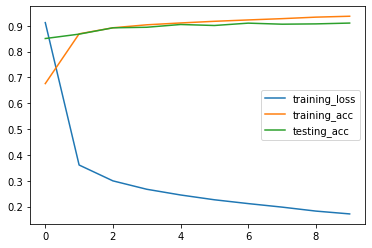

In [7]:
batch_size = 128
learning_rate = 0.03
epoch = 10
device = torch.device('cuda:3')

training_iter = torch.utils.data.DataLoader(training_data_224, batch_size=batch_size, shuffle=True)
testing_iter = torch.utils.data.DataLoader(testing_data_224, batch_size=batch_size)

# 这里是vgg11的一个简化版的模型，卷积的通道数都降低了4倍，全连接层也降低了
model = nn.Sequential(
    VGGBlock(1, 1, 16),
    VGGBlock(1, 16, 32),
    VGGBlock(2, 32, 64),
    VGGBlock(2, 64, 128),
    VGGBlock(2, 128, 128),
    nn.Flatten(),
    nn.Linear(7*7*128, 1024),
    nn.Linear(1024, 256),
    nn.Linear(256, 10),
)

def parameters_init(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
model.apply(parameters_init)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train(training_iter, testing_iter, model, loss, optimizer, device=device, epoch=epoch, plot=True)